In [13]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [14]:
def lstm_cell(lstm_size, dropout):
    single_cell = tf.nn.rnn_cell.LSTMCell(lstm_size)
    single_cell = tf.nn.rnn_cell.DropoutWrapper(single_cell, output_keep_prob=1-dropout)
    return single_cell

In [15]:
#convert series to supervised learning
def series_to_suppervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n...t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1,...t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with Nan values
    if(dropnan):
        agg.dropna(inplace=True)
    return agg


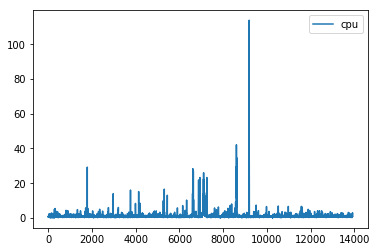

In [16]:
dataset = pd.read_csv('cpu.csv', header=None, names=['cpu'])
dataset.plot()
dataset = dataset.values

In [17]:
state_size = 8
batch_size = 4
num_layers = 2
dropout=0.2
num_steps = 5
num_features = 1
num_output_decoder = 1

data = series_to_suppervised(dataset, num_steps, num_output_decoder)
print(data.head())
x_encoder = data.iloc[:, :num_steps].values
x_encoder = np.reshape(x_encoder, [x_encoder.shape[0], x_encoder.shape[1], 1])
x_decoder = data.iloc[:, num_steps-3:num_steps].values
x_decoder = np.reshape(x_decoder, [x_decoder.shape[0], x_decoder.shape[1], 1])
y_ = data.iloc[:, -num_output_decoder:].values
y_ = np.reshape(y_, [y_.shape[0], y_.shape[1], 1])
print(x_encoder.shape, x_decoder.shape, y_.shape)

   var1(t-5)  var1(t-4)  var1(t-3)  var1(t-2)  var1(t-1)   var1(t)
5   0.668381   0.668381   0.739129   0.739129   0.558318  0.539101
6   0.668381   0.739129   0.739129   0.558318   0.539101  0.539101
7   0.739129   0.739129   0.558318   0.539101   0.539101  0.959187
8   0.739129   0.558318   0.539101   0.539101   0.959187  0.959187
9   0.558318   0.539101   0.539101   0.959187   0.959187  1.210667
(13915, 5, 1) (13915, 3, 1) (13915, 1, 1)


In [18]:
tf.reset_default_graph()
def rnn_cell(num_hidden_units, num_layers, dropout, scope):
    with tf.variable_scope(scope):
        stacked_cell = [lstm_cell(num_hidden_units, dropout) for _ in range(num_layers)]
        stacked_cell = tf.nn.rnn_cell.MultiRNNCell(stacked_cell)
    return stacked_cell

encoder_inputs = tf.placeholder(tf.float32, shape=[None, num_steps, num_features], name='encoder_inputs')
decoder_inputs = tf.placeholder(tf.float32, shape=[None, num_steps, num_features], name='decoder_inputs')
y = tf.placeholder(tf.float32, shape=[None, num_output_decoder, num_features])

with tf.variable_scope('encoder') as scope:
    encoder_stacked_cell = rnn_cell(num_hidden_units=state_size, 
                                    num_layers=num_layers, 
                                    dropout=dropout, 
                                    scope=scope)
    encoder_output, encoder_state = tf.nn.dynamic_rnn(cell=encoder_stacked_cell,
                                                     inputs=encoder_inputs,
                                                     dtype=tf.float32)
    
with tf.variable_scope('decoder') as scope:
    decoder_initial_state = encoder_state 
    decoder_stacked_cell = rnn_cell(num_hidden_units=state_size, 
                                    num_layers=num_layers, 
                                    dropout=dropout, 
                                    scope=scope)
    decoder_output, decoder_state = tf.nn.dynamic_rnn(cell=decoder_stacked_cell,
                                                     inputs=decoder_inputs,
                                                     dtype=tf.float32,
                                                     initial_state=decoder_initial_state)
    outputs = tf.reshape(decoder_output, [-1, state_size])
    
    w = tf.get_variable('w',shape=[state_size, num_steps], initializer=tf.contrib.layers.xavier_initializer())
    b = tf.get_variable('b',initializer=tf.random_uniform([num_steps],-0.1,0.1))
    
    all_outputs = tf.nn.xw_plus_b(outputs, w, b)
    print(all_outputs.shape)

(?, 5)


In [1]:
# define loss
final_output = outputs[:, -num_output_decoder]
y = tf.reshape(y, [y.shape[0],])
print(final_output.shape, y.shape)
loss = tf.reduce_mean(0.5*(final_output-y)**2)
tf.summary.scalar('loss', loss)
merged = tf.summary.merge_all()

optimizer = tf.train.AdamOptimizer(0.001).minimize(loss)

NameError: name 'outputs' is not defined

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter('.', sess.graph)
    for i in range(100):
        output, _, l, merge = sess.run([final_output, optimizer, loss, merged], feed_dict={encoder_inputs:x_encoder,
                                                                        decoder_inputs:x_encoder,
                                                                        y:y_})
        writer.add_summary(merge)
        print('epoch #', i, 'loss=', l)
    print('output:', output, 'loss:', l)